In [0]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 18 00:34:05 2019

@author: USER
"""
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array

#Reading Data
df = pd.read_excel('Merged_pollution_dataset - wo 2016 17.xlsx')
df_bbsr = df[(df['City/Town/Village/Area'] == 'Bhubaneswar') | (df['City/Town/Village/Area'] == 'Bhubaneshwar')]

df_bbsr.dtypes

df_bbsr['RSPM/PM10'] = pd.to_numeric(df_bbsr['RSPM/PM10'], errors='coerce')
df_bbsr['SO2'] = pd.to_numeric(df_bbsr['SO2'], errors='coerce')
df_bbsr['NO2'] = pd.to_numeric(df_bbsr['NO2'], errors='coerce')
df_bbsr['SPM'] = pd.to_numeric(df_bbsr['SPM'], errors='coerce')

df_bbsr.dtypes

#Data Preprocessing
df_bbsr['Location of Monitoring Station'].replace('SPCB Building, Bhubaneshwar', 'OSPCB Bldg',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Capital Police Station, Bhubaneshwar', 'Capital Police Stn.',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('IRC Vilage, Bhubaneshwar', 'IRC',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Chandrasekharpur. Bhubneswar', 'Chandrasekharpur',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Water works, Palasuni, Bhubneswar', 'Palasuni',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Patrapada, Bhubneswar', 'Patrapada',inplace=True)

df_bbsr_cps = df_bbsr[(df_bbsr['Location of Monitoring Station'] == 'OSPCB Bldg')]

#Initial Analysis
#Checking the datatypes of various columns
df_bbsr_cps.dtypes

#Converting object to Datetime
df_bbsr_cps.reset_index(inplace = True)
df_bbsr_cps = df_bbsr_cps.drop(['index'], axis = 1)
df_bbsr_cps['Sampling Date'] = pd.to_datetime(df_bbsr_cps['Sampling Date'], format='%Y-%m-%d %H:%M')
df_bbsr_cps['Sampling Date'] = pd.to_datetime(df_bbsr_cps['Sampling Date'], format='%Y-%m-%d %H:%M')


df_bbsr_cps.dtypes

#Setting default Plot Size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8

print("SUCCESS!!")
df_bbsr_cps.head()

SUCCESS!!


,Stn Code,Sampling Date,State,City/Town/Village/Area,Location of Monitoring Station,Agency,Type of Location,SO2,NO2,RSPM/PM10,SPM
0,322.0,2004-01-01,Odisha,Bhubaneswar,OSPCB Bldg,Odisha State Pollution Control Board,"Residential, Rural and other Areas",2.0,21.08,123.67,175.33
1,322.0,2004-02-01,Odisha,Bhubaneswar,OSPCB Bldg,Odisha State Pollution Control Board,"Residential, Rural and other Areas",2.5,19.83,88.67,140.33
2,322.0,2004-03-01,Odisha,Bhubaneswar,OSPCB Bldg,Odisha State Pollution Control Board,"Residential, Rural and other Areas",2.0,9.50,122.33,178.33
3,322.0,2004-04-01,Odisha,Bhubaneswar,OSPCB Bldg,Odisha State Pollution Control Board,"Residential, Rural and other Areas",2.0,12.75,106.00,177.00
4,322.0,2004-05-01,Odisha,Bhubaneswar,OSPCB Bldg,Odisha State Pollution Control Board,"Residential, Rural and other Areas",2.0,13.33,121.33,184.67


SUCCESS!!


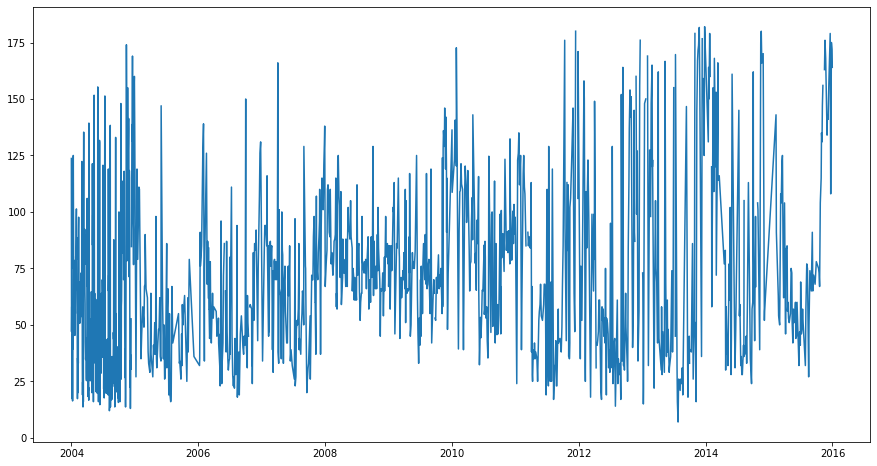

In [0]:
#Index Sorting
df_bbsr_cps = df_bbsr_cps.set_index(df_bbsr_cps['Sampling Date'])
df_bbsr_cps = df_bbsr_cps.sort_index()
# plt.plot(df_bbsr_cps['NO2'])

#Separating Year, Month, Day and Day of Week
df_bbsr_cps['year'] = df_bbsr_cps['Sampling Date'].dt.year 
df_bbsr_cps['month'] = df_bbsr_cps['Sampling Date'].dt.month 
df_bbsr_cps['day'] = df_bbsr_cps['Sampling Date'].dt.day
df_bbsr_cps['day_of_week'] = df_bbsr_cps['Sampling Date'].dt.dayofweek

#Determining Weekend
def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df_bbsr_cps['weekend'] = df_bbsr_cps['day_of_week'].apply(weekend)

#Outlier Removal
mean_cps = df_bbsr_cps['RSPM/PM10'].mean()
std_dev_cps = df_bbsr_cps['RSPM/PM10'].std() #Standard Deviation of SPM

df_bbsr_cps['RSPM/PM10'][df_bbsr_cps['RSPM/PM10'] > (mean_cps + 2.5*std_dev_cps)] = np.nan   #Replacing Outlier with "nan"
plt.plot(df_bbsr_cps['RSPM/PM10'])
df_bbsr_cps.isna().sum()

df_bbsr_cps['RSPM/PM10'] = df_bbsr_cps['RSPM/PM10'].fillna(method = 'backfill')   #Replacing "nan" with the previous values

#Dummy Encoding
df_bbsr_cps = pd.get_dummies( df_bbsr_cps, columns = ['month', 'day_of_week'] )

print("SUCCESS!!")

In [0]:
#Creating Multi-features
xf = df_bbsr_cps[['weekend', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'RSPM/PM10']]

xf.head()


,weekend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,RSPM/PM10
Sampling Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,123.67
2004-01-02,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,47.00
2004-01-03,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,58.00
2004-01-04,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,38.67
2004-01-05,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,17.33


In [0]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# choose a number of time steps
n_steps_in, n_steps_out = 50, 28

mean_spm = xf['RSPM/PM10'].mean()
std_spm = xf['RSPM/PM10'].std()

#Feature Scaling
cols = ['weekend', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'RSPM/PM10']

for field in cols:
    xf[field] = (xf[field] - xf[field].mean())/xf[field].std()


X, y = split_sequences(xf.values, n_steps_in, n_steps_out)

X_test, y_test = X[-1], y[-1]

for i in range(n_steps_out):
	X = np.delete(X, X.shape[0] - 1, 0)
	y = np.delete(y, y.shape[0] - 1, 0)

n_features = X.shape[2]

print("SUCCESS!!")

SUCCESS!!


In [0]:
X.shape

(1294, 50, 20)

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
# from keras.layers import GRU
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional


model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
# model.add(BatchNormalization())

model.add(Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(50, activation='relu'))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

print('SUCCESS!!')

SUCCESS!!


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(X, y, callbacks=[monitor], verbose=1, epochs=2000)

from sklearn.externals import joblib 
path = "/content/drive/My Drive/Journal_4_models/model_cnnlstmann.pkl"  
# Save the model as a pickle in a file 
joblib.dump(model, path) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2000
835/835 [==============================] - 3s 3ms/step - loss: 0.9953
Epoch 2/2000
835/835 [==============================] - 1s 2ms/step - loss: 0.8620
Epoch 3/2000
835/835 [==============================] - 1s 2ms/step - loss: 0.7809
Epoch 4/2000
835/835 [==============================] - 1s 2ms/step - loss: 0.7468
Epoch 5/2000
835/835 [==============================] - 1s 2ms/step - loss: 0.7262
Epoch 6/2000
835/835 [==============================] - 1s 2ms/step - loss: 0.7106
Epoch 7/2000
835/835 [==============================] - 1s 2ms/step - loss: 0.7030
Epoch 8/2000
835/835 [==============================] - 1s 2ms/step - loss: 0.6985
Epoch 9/2000
835/835 [==============================] - 1s 1ms/step - loss: 0.6935
Epoch 10/2000
835/835 [==============================] - 1s 2ms/step - loss: 0.6892
Epoch 11/2000
835/835 [==============================] - 1s 1ms/step - lo

FileNotFoundError: ignored

In [0]:
#Use only for the first time
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(model, '/content/drive/My Drive/Journal_3_models/model_cnnlstmann.pkl') 
  
print("SUCCESS!!")

SUCCESS!!


In [0]:
model = joblib.load('/content/drive/My Drive/Journal_3_models/model_cnnlstmann_OSPCB.pkl')

In [0]:
x_input = array(X_test)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=2)
print((yhat[0]*std_spm)+mean_spm)
print((y_test*std_spm)+mean_spm)

[ 25.469166  25.007954  89.43562   20.704414  40.08309   85.90212
 107.66701   94.71321   23.770535   6.662781  20.49773   49.78225
  62.47338   25.9623   105.61723  112.99434   95.89228  128.89423
 148.67017  171.43436  135.16513  106.980835 118.034706  64.94652
  32.07886  156.31247  147.07181   68.073265]
[ 65.  91.  65.  72.  68.  78.  75.  73.  67. 104. 115. 135. 131. 147.
 156. 163. 163. 176. 168. 134. 143. 141. 156. 179. 108. 175. 172. 164.]


In [0]:
X_test.shape

(50, 20)

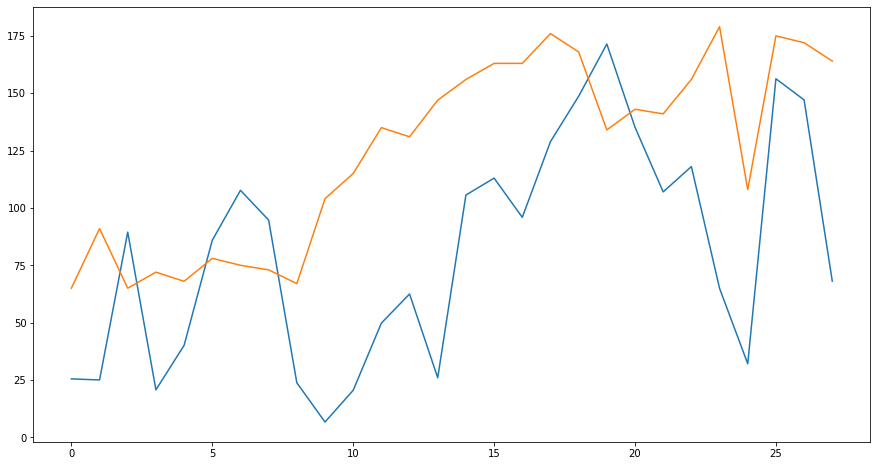

In [0]:
# fig, ax = plt.subplots()
plt.plot((yhat[0]*std_spm)+mean_spm)
plt.plot((y_test*std_spm)+mean_spm)
plt.show()

In [0]:
print(yhat)
print(y_test)

[[-1.167085   -1.1790813   0.49669898 -1.2910174  -0.786973    0.40479174
   0.97090197  0.63397044 -1.2112669  -1.6562439  -1.2963934  -0.53469545
  -0.20459585 -1.1542585   0.9175869   1.1094673   0.66463834  1.5230277
   2.037405    2.6295073   1.6861352   0.95305467  1.2405686  -0.14026897
  -0.99516517  2.236183    1.9958314  -0.05894132]]
[-0.13887772  0.53738898 -0.13887772  0.04319408 -0.06084695  0.19925563
  0.12122485  0.06920434 -0.08685721  0.87552232  1.16163516  1.68184031
  1.57779928  1.9939634   2.22805571  2.41012752  2.41012752  2.74826086
  2.5401788   1.65583005  1.88992237  1.83790185  2.22805571  2.82629164
  0.97956335  2.72225061  2.64421983  2.43613777]


In [0]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rms = sqrt(mean_squared_error(y_test, yhat))
# print(rms)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms = sqrt(mean_squared_error(y_test, yhat))
print(rms)

mse = mean_squared_error(y_test, yhat)
print(mse)

mae = mean_absolute_error(y_test, yhat)
print(mae)

mape = mean_absolute_percentage_error(y_test, yhat)
print(mape)

60.81284629195851
3698.2022741293717
52.214531489780974
44.52481168230799


In [0]:
x_ann = []

for inp_val in X:
  x_input_ann = inp_val.reshape((1, n_steps_in, n_features))
  y_newpred = model.predict(x_input_ann, verbose = 1)
  x_ann.append(y_newpred)
  
x_ann = array(x_ann)


1/1 [==============================] - 0s 16ms/step


In [0]:
x_ann_new = x_ann[:, 0, :]
x_ann_new.shape

(1294, 28)

In [0]:
print(x_ann_new.shape, y.shape)

(1294, 28) (1294, 28)


In [0]:
y

array([[-0.42499055, -0.44241743, -0.49443794, ...,  0.46794159,
         0.51137872,  0.16466198],
       [-0.44241743, -0.49443794, -0.42499055, ...,  0.51137872,
         0.16466198,  0.57198262],
       [-0.49443794, -0.42499055, -0.02625331, ...,  0.16466198,
         0.57198262, -0.14746111],
       ...,
       [-0.45100081, -0.50302133, -0.3989803 , ...,  0.17324537,
         0.12122485, -1.12726751],
       [-0.50302133, -0.3989803 ,  0.12122485, ...,  0.12122485,
        -1.12726751, -0.52903158],
       [-0.3989803 ,  0.12122485,  0.06920434, ..., -1.12726751,
        -0.52903158,  0.0952146 ]])

In [0]:
# from sklearn import svm
# from sklearn.svm import SVR

# svc = svm.SVC(kernel ='linear', C = 1).fit(x_ann_new, y)

# clf = SVR(C=1.0, epsilon=0.2)
# model_new = clf.fit(x_ann_new, y[:,0])

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# regr_multirf = MultiOutputRegressor(SVR(kernel='rbf'))

regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0))
regr_multirf.fit(x_ann_new, y)

MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.1, gamma='scale', kernel='rbf',
                                   max_iter=-1, shrinking=True, tol=0.001,
                                   verbose=False),
                     n_jobs=None)

In [0]:
y_test.shape
y_test_new = y_test.reshape(y_test.shape[0], -1)

y_test_new.shape
y_test

array([-0.13887772,  0.53738898, -0.13887772,  0.04319408, -0.06084695,
        0.19925563,  0.12122485,  0.06920434, -0.08685721,  0.87552232,
        1.16163516,  1.68184031,  1.57779928,  1.9939634 ,  2.22805571,
        2.41012752,  2.41012752,  2.74826086,  2.5401788 ,  1.65583005,
        1.88992237,  1.83790185,  2.22805571,  2.82629164,  0.97956335,
        2.72225061,  2.64421983,  2.43613777])

In [0]:
y_test_new = y_test_new.T
y_test_new

array([[-0.13887772,  0.53738898, -0.13887772,  0.04319408, -0.06084695,
         0.19925563,  0.12122485,  0.06920434, -0.08685721,  0.87552232,
         1.16163516,  1.68184031,  1.57779928,  1.9939634 ,  2.22805571,
         2.41012752,  2.41012752,  2.74826086,  2.5401788 ,  1.65583005,
         1.88992237,  1.83790185,  2.22805571,  2.82629164,  0.97956335,
         2.72225061,  2.64421983,  2.43613777]])

In [0]:
yhat_new = regr_multirf.predict(y_test_new)

In [0]:
# x_ann_new_input = array(y_test_new)
# x_ann_new_input = x_ann_new_input.reshape((1, n_steps_in, n_features))
# yhat_new = model_new.predict(x_ann_new_input, verbose=2)
# print((yhat_new[0]*std_spm)+mean_spm)
# print((y_test_new*std_no2)+mean_no2)

print(yhat_new)
print(y_test_new)

[[-4.90885484e-01 -1.93330882e-01 -3.56642187e-01 -1.85723363e-01
  -3.16052411e-01 -1.90224738e-01  1.41787421e-01 -2.37472779e-03
   1.49153467e-01  8.92203671e-01  1.37284614e+00  1.76995670e+00
   1.89771976e+00  2.15305427e+00  2.48754875e+00  2.41040628e+00
   2.25320475e+00  2.59274682e+00  2.46679624e+00  1.77689267e+00
   2.06838909e+00  2.02908588e+00  2.41817063e+00  2.25262075e+00
   1.91547385e+00  2.40580392e+00  2.45708595e+00  2.28305453e+00]]
[[-0.13887772  0.53738898 -0.13887772  0.04319408 -0.06084695  0.19925563
   0.12122485  0.06920434 -0.08685721  0.87552232  1.16163516  1.68184031
   1.57779928  1.9939634   2.22805571  2.41012752  2.41012752  2.74826086
   2.5401788   1.65583005  1.88992237  1.83790185  2.22805571  2.82629164
   0.97956335  2.72225061  2.64421983  2.43613777]]


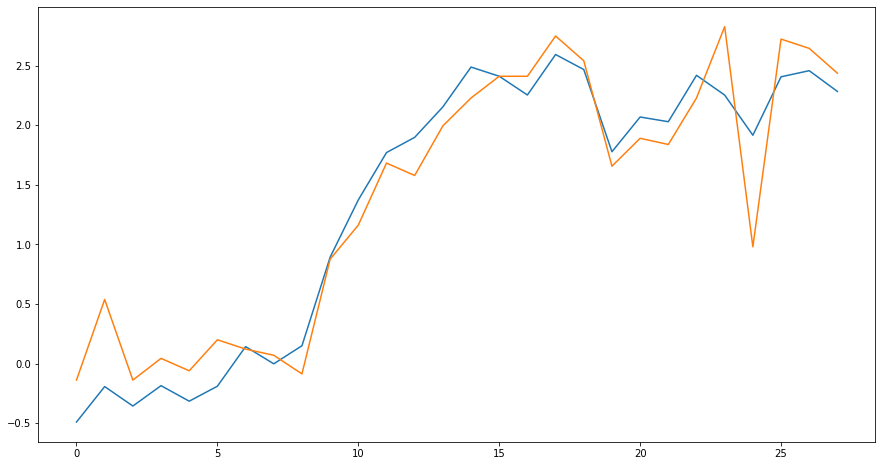

In [0]:
# fig, ax = plt.subplots()
plt.plot((yhat_new[0]))
plt.plot((y_test_new[0]))
plt.show()

In [0]:
y_test_new = (y_test_new[0]*std_spm)+mean_spm
yhat_new = (yhat_new[0]*std_spm)+mean_spm

In [0]:
print(yhat_new)
print(y_test_new)

[ 51.46657906  62.90647355  56.6277466   63.19895505  58.18827619
  63.02589351  75.79055604  70.24804464  76.07375376 104.6413373
 123.1202956  138.38775545 143.29978132 153.11646666 165.97656545
 163.01071733 156.96688927 170.02104936 165.17870681 138.6544185
 149.86139774 148.3503321  163.30922855 156.94443633 143.98236169
 162.83377323 164.80538116 158.11450491]
[ 65.  91.  65.  72.  68.  78.  75.  73.  67. 104. 115. 135. 131. 147.
 156. 163. 163. 176. 168. 134. 143. 141. 156. 179. 108. 175. 172. 164.]


In [0]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rms_new = sqrt(mean_squared_error(y_test_new, yhat_new))
# print(rms_new)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms_new = sqrt(mean_squared_error(y_test_new, yhat_new))
print(rms_new)

mse_new = mean_squared_error(y_test_new, yhat_new)
print(mse_new)

mae_new = mean_absolute_error(y_test_new, yhat_new)
print(mae_new)

mape_new = mean_absolute_percentage_error(y_test_new, yhat_new)
print(mape_new)

12.202064222939107
148.89037130073058
9.323152065007523
8.794259262021345
